In [1]:
import pandas as pd
import joblib
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [2]:
train = pd.read_parquet('../data/processed/train.parquet')
test = pd.read_parquet('../data/processed/test.parquet')

scaler = joblib.load('../models/scaler.joblib')

In [10]:
train

,date,cheese,milk,dulce_leche,eggs,porks,vegetables,cheese_revenue,milk_revenue,dulce_leche_revenue,...,porks_revenue,vegetables_revenue,season,year,month,week_year,harvest_season,month_sin,month_cos,target
0,2020-01-01,-1.555556,-0.503989,-0.432432,-0.630137,-0.500000,-0.699301,300,900,50,...,300,20,Summer,2020,1,1,0,5.000000e-01,8.660254e-01,-1.333333
1,2020-02-01,-1.333333,-0.485218,-0.648649,-0.575342,-0.500000,-0.643357,375,930,30,...,300,24,Summer,2020,2,5,0,8.660254e-01,5.000000e-01,-1.200000
2,2020-03-01,-1.200000,-0.466448,-0.540541,-0.410959,-0.500000,-0.475524,420,960,40,...,300,36,Summer,2020,3,9,1,1.000000e+00,6.123234e-17,-1.111111
3,2020-04-01,-1.111111,-0.522759,-0.756757,-0.520548,-0.500000,-0.279720,450,870,20,...,300,50,Fall,2020,4,14,1,8.660254e-01,-5.000000e-01,-0.888889
4,2020-05-01,-0.888889,-0.447677,-0.648649,-0.356164,-0.500000,-0.139860,525,990,30,...,300,60,Fall,2020,5,18,1,5.000000e-01,-8.660254e-01,-0.666667
5,2020-06-01,-0.666667,-0.316283,-0.324324,-0.191781,-0.333333,0.000000,600,1200,60,...,600,70,Fall,2020,6,23,0,1.224647e-16,-1.000000e+00,-0.444444
6,2020-07-01,-0.444444,-0.278742,-0.108108,-0.082192,-0.166667,0.139860,675,1260,80,...,900,80,Winter,2020,7,27,0,-5.000000e-01,-8.660254e-01,-0.222222
7,2020-08-01,-0.222222,-0.241201,0.000000,-0.027397,-0.166667,0.279720,750,1320,90,...,900,90,Winter,2020,8,31,0,-8.660254e-01,-5.000000e-01,0.000000
8,2020-09-01,0.000000,-0.203660,0.108108,0.027397,0.000000,0.419580,825,1380,100,...,1200,100,Winter,2020,9,36,0,-1.000000e+00,-1.836970e-16,0.222222
9,2020-10-01,0.222222,-0.166119,0.324324,0.082192,0.166667,0.559441,900,1440,120,...,1500,110,Spring,2020,10,40,0,-8.660254e-01,5.000000e-01,0.444444


In [3]:
X_train = train.drop('target', axis=1)
X_train = X_train.drop(columns=['date']) 
X_train = X_train.drop(columns=['season']) 
y_train = train['target']
X_test = test.drop('target', axis=1)
X_test = X_test.drop(columns=['date']) 
X_test = X_test.drop(columns=['season']) 
y_test = test['target']

In [4]:
y_test.head()

47   -0.666667
48   -0.444444
49   -0.222222
50   -0.311111
51    0.000000
Name: target, dtype: float64

In [5]:
baseline = DummyRegressor(strategy='mean')
baseline.fit(X_train, y_train)
print(f"MAE Baseline: {mae(y_test, baseline.predict(X_test)):.2f}")

MAE Baseline: 0.47


In [6]:
X_train = X_train.drop(columns=['date']) if 'date' in X_train.columns else X_train

# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf_scores = cross_val_score(rf, X_train, y_train,
                          cv=TimeSeriesSplit(n_splits=5),
                          scoring='neg_mean_absolute_error')
print(f"RF MAE Médio: {-rf_scores.mean():.2f}")

RF MAE Médio: 0.75


In [7]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5]
}

grid = GridSearchCV(RandomForestRegressor(),
                   param_grid,
                   cv=TimeSeriesSplit(n_splits=3),
                   scoring='neg_mean_absolute_error')
grid.fit(X_train, y_train)

print(f"Melhores parâmetros: {grid.best_params_}")

Melhores parâmetros: {'max_depth': 3, 'n_estimators': 100}


Text(0, 0.5, 'Predito')

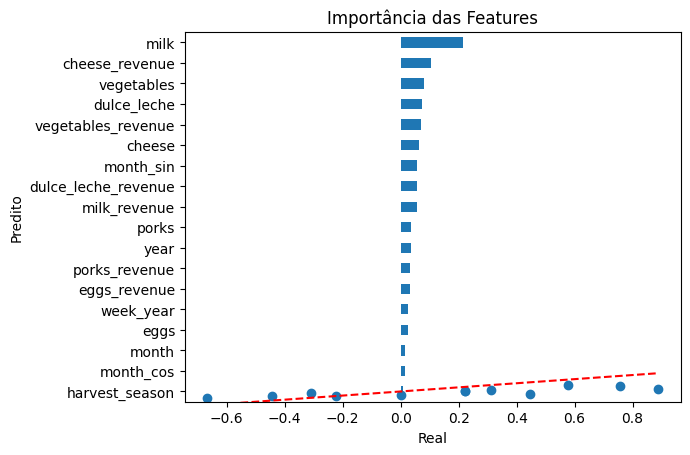

In [8]:
# Feature Importance
pd.Series(grid.best_estimator_.feature_importances_,
          index=X_train.columns).sort_values().plot.barh()
plt.title('Importância das Features');

# Predições vs Real
plt.scatter(y_test, grid.predict(X_test))
plt.plot([y_test.min(), y_test.max()], 
         [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Real')
plt.ylabel('Predito')

In [9]:
joblib.dump(grid.best_estimator_, '../models/best_model.joblib')

['../models/best_model.joblib']